In [6]:
import numpy as np
from PIL import Image
import zlib
import random
import matplotlib.pyplot as plt


In [7]:
def text_to_bits(text):
    return ''.join(format(byte, '08b') for byte in text)

def bits_to_bytes(bits):
    return bytes([int(bits[i:i+8], 2) for i in range(0, len(bits), 8)])

def xor_encrypt(text, key):
    return bytes([b ^ ord(key) for b in text])

def xor_decrypt(encrypted_bytes, key):
    return bytes([b ^ ord(key) for b in encrypted_bytes])


In [8]:
def embed_steganography(image_path, message, key, output_path):
    # Load image
    img = Image.open(image_path).convert('RGB')
    data = np.array(img)
    flat_data = data.flatten()

    # Encrypt + compress
    xor_encrypted = xor_encrypt(message.encode('utf-8'), key)
    compressed = zlib.compress(xor_encrypted)

    # Append delimiter
    compressed += b'###END###'

    bits = text_to_bits(compressed)

    if len(bits) > len(flat_data):
        raise ValueError("Message too large for this image!")

    # Generate pseudo-random positions
    random.seed(ord(key))  # key-based seed
    positions = list(range(len(flat_data)))
    random.shuffle(positions)

    # Embed bits in random LSB positions
    for i, bit in enumerate(bits):
        pos = positions[i]
        flat_data[pos] = (flat_data[pos] & 254) | int(bit)


    # Save new image
    new_data = flat_data.reshape(data.shape)
    stego_img = Image.fromarray(new_data.astype(np.uint8))
    stego_img.save(output_path)
    print(f"✅ Message embedded and saved as: {output_path}")


In [9]:
def extract_steganography(image_path, key):
    img = Image.open(image_path).convert('RGB')
    data = np.array(img)
    flat_data = data.flatten()

    # Generate pseudo-random positions
    random.seed(ord(key))
    positions = list(range(len(flat_data)))
    random.shuffle(positions)

    # Extract bits
    bits = ''
    for pos in positions:
        bits += str(flat_data[pos] & 1)
        if len(bits) % 8 == 0:
            # Check for delimiter
            current_bytes = bits_to_bytes(bits)
            if b'###END###' in current_bytes:
                break

    # Remove delimiter
    extracted_bytes = bits_to_bytes(bits)
    extracted_bytes = extracted_bytes.replace(b'###END###', b'')

    # Decompress + decrypt
    decompressed = zlib.decompress(extracted_bytes)
    decrypted = xor_decrypt(decompressed, key)

    return decrypted.decode('utf-8')


Saving beautiful-scenery-summit-mount-everest-covered-with-snow-white-clouds.png to beautiful-scenery-summit-mount-everest-covered-with-snow-white-clouds.png
✅ Message embedded and saved as: /content/stego_image.png


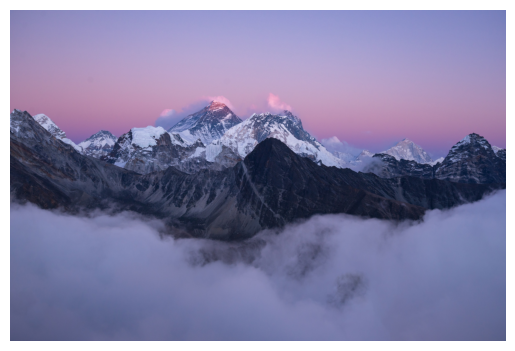

✅ Retrieved message: This is a secure hidden message!


In [11]:
# Example usage

# Upload an image
from google.colab import files
uploaded = files.upload()  # Choose an image (lossless PNG recommended)
image_path = next(iter(uploaded))  # Get the uploaded file name

output_path = '/content/stego_image.png'
message = "This is a secure hidden message!"
key = 'K'

# Embed
embed_steganography(image_path, message, key, output_path)

# Show stego image
stego_img = Image.open(output_path)
plt.imshow(stego_img)
plt.axis('off')
plt.show()

# Extract
retrieved = extract_steganography(output_path, key)
print(f"✅ Retrieved message: {retrieved}")
